In [275]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import APFcommonstuff as APF


from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.coordinates import Angle

pandas.set_option("display.precision", 8)

In [276]:
# importantly, this correlation analysis must have cleaned data to be useful. 
data = pandas.read_csv('final_data_cleaned.csv')

In [277]:
HD10700_coords = SkyCoord.from_name('HD 10700')
HD185144_coords = SkyCoord.from_name('HD 185144')
HD9407_coords = SkyCoord.from_name('HD 9407')
stars = {'HD10700_APF.vels': HD10700_coords, 
         'HD185144_APF.vels': HD185144_coords, 
         'HD9407_APF.vels': HD9407_coords}

In [136]:
for star_name, coord in stars.items():
    print(star_name, Angle(coord.ra).degree, Angle(coord.dec).degree,
          coord.ra, coord.dec)
    
"""
HD9407     01 34 33.26 +68 56 53.28
HD10700    01 44 04.08 -15 56 14.92
HD185144   19 32 21.59 +69 39 40.24
"""

HD10700 26.01701426083 -15.93747959778 26d01m01.2513s -15d56m14.9266s
HD185144 293.08995957917 69.66117631583 293d05m23.8545s 69d39m40.2347s
HD9407 23.638601620407 68.9481355878409 23d38m18.9658s 68d56m53.2881s


'\nHD9407     01 34 33.26 +68 56 53.28\nHD10700    01 44 04.08 -15 56 14.92\nHD185144   19 32 21.59 +69 39 40.24\n'

In [278]:
#EarthLocation.get_site_names() # downloads all names of observatories in directory.

# For each a given elevation + azimuth, check distance to all three stars
# and both daylight savings times and choose the one that's
# both minimum angle distance and below than some angle threshold (3 degrees?).
def closest_star(az_0, el_0, DateTimeLocal):
    lick = EarthLocation.of_site('Lick Observatory')
    utcoffsets = [-7*u.hour, -8*u.hour]
    if az_0 >= 0:
        positive_az = az_0
    else:
        #print('az_0 < 0.')
        positive_az = 360 + az_0
        #print('positive_az = {}'.format(positive_az))
    actual_loc = np.array([positive_az, el_0])
    min_dist = 100 # degrees.
    for star_name, coords in stars.items():
        for utcoffset in utcoffsets:
            #time = Time(1436589861.0, format='unix')
            #print(star.transform_to(AltAz(obstime=time,location=lick)))
            time = Time(DateTimeLocal, format='iso') - utcoffset
            altaz = coords.transform_to(AltAz(obstime=time,location=lick))
            EL = Angle(altaz.alt).degree
            AZ = Angle(altaz.az).degree
            #print(AZ, EL)
            test_loc = np.array([AZ, EL])
            dist = np.linalg.norm(actual_loc - test_loc)
            if dist < min_dist:
                min_dist = dist
                min_dist_star_name = star_name
            print(actual_loc, test_loc, dist)
            
    if min_dist < 5.: # degrees.
        print(min_dist_star_name)
        return min_dist_star_name
            #else:
                
    return '' 

closest_star(202.4085, 33.8005, '2015-01-25 18:47:47.328013')


[202.4085  33.8005] [184.98332822  36.64737508] 17.656197471806287
[202.4085  33.8005] [202.37270544  33.80573436] 0.03617525961593147
[202.4085  33.8005] [335.97904968  32.26767091] 133.5793446105326
[202.4085  33.8005] [338.75482631  27.64941934] 136.48500463911122
[202.4085  33.8005] [355.64842963  58.11963493] 155.1576500058508
[202.4085  33.8005] [346.37235769  56.22199143] 145.69940150056243
HD10700_APF.vels


'HD10700_APF.vels'

In [ ]:
#time = Time('2015-01-25 18:47:47.328013', format='iso')
#print(HD10700.transform_to(AltAz(obstime=time,location=lick)))


# Initialize this new column to just have empty strings. 
data['starID_corrected'] = ''

# Set all stars with AZ greater than 100 to be HD10700.
data.loc[data['AZ'] > 100, 'starID_corrected'] = 'HD10700_APF.vels' 
    
len(data.loc[data['starID_corrected'].str.match('HD10700')])

#data.loc[data['starID_corrected'] == 'HD10700_APF.vels'][['DateTimeLocal', 'starID_corrected']]

In [ ]:
# This cell takes about a minute. 
# For each of 1500 records, check distance to all three stars and choose the one that's
# both minimum and less than some threshold (3 degrees?).
for index, row in data.iterrows():
    #star = closest_star(row['AZ'], row['EL'], row['DateTimeLocal'])
    if not row['starID_corrected'] == 'HD10700_APF.vels':
        print("Index: {}".format(index))
        star_ID = closest_star(row['AZ'], row['EL'], row['DateTimeLocal'])
        data.at[index, 'starID_corrected'] = star_ID


#data.loc[data['AZ'] < 100, 'starID_corrected'] = 'HD10700_APF.vels' 

In [273]:
data.loc[data['AZ'] < 0 ][['EL', 'AZ', 'DateTimeLocal', 'starID_corrected']].head()
#closest_star(-24.5503, 33.5059	, '2015-01-04 18:54:44.640013')

,EL,AZ,DateTimeLocal,starID_corrected
312,38.7183,-25.8104,2015-01-02 18:01:33.023971,HD185144_APF.vels
313,38.5812,-25.7968,2015-01-02 18:03:07.200004,HD185144_APF.vels
314,38.4470,-25.7825,2015-01-02 18:04:41.375997,HD185144_APF.vels
315,33.6410,-24.6021,2015-01-04 18:53:08.736007,HD185144_APF.vels
316,33.5059,-24.5503,2015-01-04 18:54:44.640013,HD185144_APF.vels


In [281]:
len(data.loc[data['starID_corrected']==''])

3

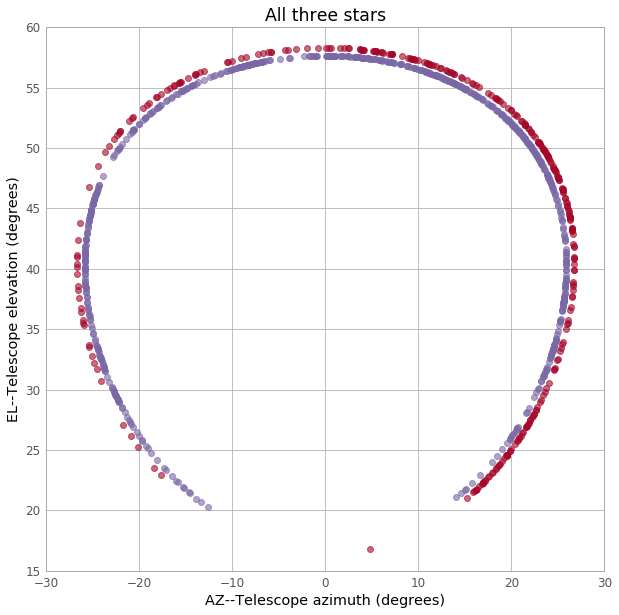

In [282]:
# visually check with color coding to see that stars were't falsely identified. 
def plot_az_el(data, s=None, xylim=None):  
    fig = plt.figure(figsize=(10, 10))
    if not s:
        s = 40
        
    plt.title('All three stars')
    #plt.scatter(data[xname], data[yname], s=40, alpha=0.1)
    plt.scatter(data.loc[data['starID_corrected'] == 'HD10700_APF.vels'].AZ, 
              data.loc[data['starID_corrected'] == 'HD10700_APF.vels'].EL,
               alpha = 0.2)
    plt.scatter(data.loc[data['starID_corrected'] == 'HD185144_APF.vels'].AZ, 
              data.loc[data['starID_corrected'] == 'HD185144_APF.vels'].EL,
               alpha = 0.6)
    plt.scatter(data.loc[data['starID_corrected'] == 'HD9407_APF.vels'].AZ, 
              data.loc[data['starID_corrected'] == 'HD9407_APF.vels'].EL,
               alpha = 0.6)
    plt.xlabel(APF.shortname_and_units('AZ'))
    plt.ylabel(APF.shortname_and_units('EL'))
    if xylim:
        plt.xlim(xylim[0])
        plt.ylim(xylim[1])
                
plot_az_el(data, xylim=[[-30, 30],[15, 60]])

In [283]:
def write_to_csv(data, filename):
    data.to_csv(filename, index=False)
    
write_to_csv(data, 'final_data_cleaned_fixed_starIDs.csv')